# Playing Cards Prediction Algorithm

## Setup Dependencies

To run the algorithm, ensure the following Python packages are installed:

- **matplotlib:** Ensures the Matplotlib library is up-to-date for data visualization.
- **pandas:** Installs the pandas library, which is useful for data manipulation and analysis.
- **scikit-learn:** A comprehensive machine learning library.


In [28]:
# install matplotlib
%pip install -U matplotlib

# install pandas
%pip install pandas

# install scikit-learn
%pip install -U scikit-learn

# install tqdm
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Import Libraries
Import essential libraries for deep learning, data handling, and visualization

In [29]:
# import modules
import torch
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
from tqdm import tqdm

import matplotlib.pyplot as plt # For data visualization
import pandas as pd # tabular data handling
import numpy as np
import sys

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.11.7 | packaged by conda-forge | (main, Dec 23 2023, 14:38:07) [Clang 16.0.6 ]
PyTorch version 2.1.2
Torchvision version 0.16.2
Numpy version 1.26.3
Pandas version 2.1.4


## Set up the Dataset

### Playing Card Dataset Class

A custom dataset class, `PlayingCardDataset`, is defined for handling the playing card dataset. This class allows easy management of the playing card dataset and enables the creation of reusable functions for dataset-related operations. The class is inherited from Python's `Dataset` class.


In [30]:
# Dataset https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification
# initialize a class for handling the dataset so that we can create custom reusable functions for opreations related to the dataset  
# this is inherited from python's Dataset class
class PlayingCardDataset(Dataset):
    def __init__(self,data_dir,transform=None):
        # use ImageFolder function of torchvision -> It helps in managing labels for images by assuming images are named with labels
        self.data = ImageFolder(data_dir, transform=transform)
    def __len__(self):
        return len(self.data)
    def __getitem__(self,idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

### Testing out the dataset
Dataset: [Cards Image Dataset-Classification](https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification)

An instance of the `PlayingCardDataset` class is created using the training set located in the `./dataset/train/` directory. The `len(dataset)` call then retrieves the number of samples in the dataset, which is printed out.


In [31]:
dataset = PlayingCardDataset(data_dir='./dataset/train/')
len(dataset)

7624

An image and its corresponding label are retrieved from the dataset at a random index. The image (PyTorch tensor) can be printed to get the output of the image of that particular index.

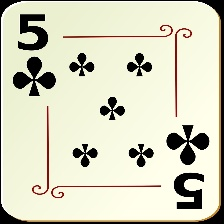

In [32]:
# test out the dataset
image, lable = dataset[1200]
image

The label (PyTorch tensor) can be printed to get the output of the label.

In [33]:
print(lable)

8


### Create Label Mapping Dictionary
A dictionary named target_to_class is created to establish a mapping between the numeric labels and their corresponding class names in the dataset. The keys of the dictionary represent the numeric labels, and the values are the associated class names

In [34]:
# Create a dictionary to identify the meaning of each number in the label
data_dir = './dataset/train/'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

### Data Augmentation

The resizing operation standardizes all images to a consistent size of `128x128` pixels, and the transformation subsequently converts the data into PyTorch tensors. This preprocessing is essential for the following reasons:

1. **Consistency:** Uniform image sizes facilitate consistent input dimensions for neural networks, ensuring compatibility and streamlining the training process.

2. **Tensor Conversion:** Transforming the data into PyTorch tensors is a prerequisite for leveraging the PyTorch deep learning framework. Tensors are the fundamental data structure used for training neural networks.

Random horizontal flipping, and rotation increase the variability in the training dataset without actually increasing the number of labeled images.


In [35]:
# Resize images to a consistent size and transform data into a tensor
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])
dataset = PlayingCardDataset(data_dir, transform)

Image and its corresponding label are retrieved from the dataset at a selected index. The `image.shape` operation is used to inspect the shape of the image tensor. 

The resulting shape can be explained as follows: 
* The shape of the image tensor is (3, 128, 128).
  * 3: Represents the number of color channels (RGB).
  * 128: Denotes the height of the image.
  * 128: Denotes the width of the image.


In [36]:
image, label = dataset[100]
image.shape

torch.Size([3, 128, 128])

A loop is used to iterate over the dataset, retrieving one image and its corresponding label. The loop is interrupted after the first iteration using the break statement. This loop structure allows to perform operations on each image-label pair in the dataset.

In [37]:
# one iteration over dataset
for image, label in dataset:
    break

### DataLoader Configuration

A DataLoader is configured for the dataset, facilitating more efficient model training by processing data in batches. By employing a DataLoader with batch processing, model training benefits from improved efficiency and accelerated convergence, as the model updates its weights based on batches of data rather than individual samples.


In [38]:
dataLoader = DataLoader(dataset, batch_size=32, shuffle=True)
# model trains faster when it takes data as batches

#### Batch Processing with DataLoader
The configured DataLoader is utilized to iterate over batches of images and labels from the dataset. The loop is interrupted after the first batch using the break statement. 

In [39]:
for images, labels in dataLoader:
    break

#### Inspecting batched data

The shapes of the batched images and labels can be inspected.

**Explanation:**

- `images`: The shape is (32, 3, 128, 128).
  - 32: Represents the batch size, indicating that there are 32 images in one batch.
  - 3: Denotes the number of color channels (RGB).
  - 128: Denotes the height of each image.
  - 128: Denotes the width of each image.

- `labels`: The shape is (32,).
  - 32: Corresponds to the batch size, indicating labels for 32 images.


In [40]:
# Print the shapes of the batched images and labels
print("Images Shape:", images.shape)
print("Labels Shape:", labels.shape)

Images Shape: torch.Size([32, 3, 128, 128])
Labels Shape: torch.Size([32])


The labels variable is inspected after a batch has been processed using the DataLoader. The observation is made that due to the shuffle configuration, the labels in the batch are now in a **random order**

In [41]:
labels
# because of the shuffle, labels are now random

tensor([42,  8, 19, 22, 35, 18, 13,  8, 14,  9, 23,  3, 47, 28,  3, 41, 37, 30,
        37, 21, 51, 34, 22, 49, 27, 16,  2,  2, 33, 16, 41,  8])

# Creating the Model

A Convolutional Neural Network (CNN) is built here with the following specifications:

- **Convolutional Layers:**
    - `conv1` and `conv2`: Two convolutional layers with ReLU activation functions.
    - `pool1` and `pool2`: Max-pooling layers to downsample the spatial dimensions.

- **Fully Connected Layers:**
    - `fc1` and `fc2`: Two fully connected layers with ReLU activation functions in between.

- **Input and Output:**
    - Input images are assumed to have three channels (RGB).
    - The output layer has `num_classes` neurons, representing the number of classes for classification.

- **Forward Pass:**
    - The forward method defines the forward pass of the network.


In [42]:
class CardClassifierCNN(nn.Module):
    def __init__(self, num_classes=53):
        super(CardClassifierCNN, self).__init__()
        # Where we define all the parts of the model
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        # Make a classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )

    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output

## Exploring the created model
Here we instantiate an object of the CardClassifierCNN class with the specified number of classes (53) and prints out the model architecture

In [43]:
model = CardClassifierCNN(num_classes=53)
print(model)

CardClassifierCNN(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kerne

## Testing out the Model
In here the model is used to perform inference on a batch of images (images). The resulting output shape is inspected afterwards.

In [44]:
# testing out the model
example_out = model(images)
example_out.shape # [batch_size, num_classes]

torch.Size([32, 53])

# Training the Model
In the following section, the deep learning model, specifically designed for classifying playing cards, is trained on a dataset of card images. The training process involves optimizing the model's weights based on the provided dataset, with the ultimate goal of enabling the model to accurately predict the class of unseen card images.

## Loss Function and Optimizer Configuration

- **Loss Function (nn.CrossEntropyLoss):**
  - Utilizes the Cross Entropy Loss, suitable for multi-class classification tasks.
  - The chosen loss function computes the negative log likelihood between the predicted probabilities and the true class labels.

- **Optimizer (optim.Adam):**
  - Utilizes the Adam optimizer, a popular choice for deep learning tasks.
  - Adjusts model parameters during training to minimize the defined loss.


In [45]:
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

The computed loss is showcased using the CrossEntropyLoss function applied to the model's output (example_out) and the corresponding ground truth labels (labels). Additionally, the shapes of the model output and labels are printed for reference

In [46]:
criterion(example_out, labels)
print(example_out.shape, labels.shape)

torch.Size([32, 53]) torch.Size([32])


## Setup Datasets

Here, datasets and DataLoaders are configured for training, validation, and testing.

### Dataset Configuration:
- Instances of the `PlayingCardDataset` class are created for the training, validation, and test sets.
- Transformations, such as resizing and tensor conversion, are applied during dataset instantiation.

### DataLoader Configuration:
- DataLoaders are set up for each dataset, allowing efficient batch processing during model training and evaluation.
- The training DataLoader is configured with shuffling enabled to introduce randomness during training.

These configurations set the stage for training and evaluating the Card Classifier CNN model on distinct datasets.


In [47]:
train_folder = './dataset/train/'
valid_folder = './dataset/valid/'
test_folder = './dataset/test/'

train_dataset = PlayingCardDataset(train_folder, transform=transform)
val_dataset = PlayingCardDataset(valid_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## Early Stopping Implementation

This defines an `EarlyStopping` class which will be used in training the machine learning model to prevent overfitting and improve efficiency.<br>
Here's an overview of the class:

- `EarlyStopping` is a class designed to monitor the training process and stop it early if certain conditions are met.

- Parameters:
  - `patience`: Number of epochs with no improvement after which training will be stopped.
  - `min_delta`: Minimum change in the monitored quantity to qualify as an improvement.
  - `restore_best_weights`: Whether to restore the model to the best state when early stopping is triggered.

- The class keeps track of the best model and loss during training, and if the validation loss does not improve for a specified number of epochs (`patience`), training is stopped early.

- The `__call__` method is invoked during each epoch to evaluate whether early stopping conditions are met.

- The code also determines the device (`"mps"`, `"cuda"`, or `"cpu"`) to use based on the availability of GPU or MPS (Apple Silicon Processors).

This implementation aims to enhance the training process by avoiding unnecessary epochs when the model has already converged or when further training does not significantly improve performance.





In [48]:
# Early stopping
import copy

class EarlyStopping():
  def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
    self.patience = patience
    self.min_delta = min_delta
    self.restore_best_weights = restore_best_weights
    self.best_model = None
    self.best_loss = None
    self.counter = 0
    self.status = ""

  def __call__(self, model, val_loss):
    if self.best_loss == None:
      self.best_loss = val_loss
      self.best_model = copy.deepcopy(model)
    elif self.best_loss - val_loss > self.min_delta:
      self.best_loss = val_loss
      self.counter = 0
      self.best_model.load_state_dict(model.state_dict())
    elif self.best_loss - val_loss < self.min_delta:
      self.counter += 1
      if self.counter >= self.patience:
        self.status = f"Stopped on {self.counter}"
        if self.restore_best_weights:
          model.load_state_dict(self.best_model.state_dict())
        return True
    self.status = f"{self.counter}/{self.patience}"
    return False

# Make use of a GPU or MPS (Apple) if one is available.
device = "mps" if torch.backends.mps.is_available() \
    else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


## Learning Rate Scheduler
Using a learning rate scheduler can help in reducing the learning rate as the training progresses, which often leads to better performance.

In [49]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

## Training the Card Classifier CNN Model
 the Card Classifier CNN model is trained over multiple epochs using the training and validation datasets. Key steps include moving data to the selected device (GPU, MPS, or CPU), computing the loss, backpropagation, and optimization.<br>
- Training Loop:
    - The model is trained over multiple epochs, with each epoch consisting of a training and validation phase.
    - Training data is processed in batches, and the model parameters are updated to minimize the loss.
- Validation:
    - The model is evaluated on the validation dataset to monitor its performance on unseen data.
- Device Selection:
    - The device is selected based on availability (GPU, MPS, or CPU) to leverage hardware acceleration.
<br>
This training loop provides insights into the model's learning progress, and the validation loss helps assess its generalization ability. Adjust hyperparameters, such as the learning rate, based on the training results.

In [50]:
num_epochs = 100
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Optimize performance on Apple Silicon Processors
if torch.backends.mps.is_available():
    device = torch.device("mps")

print("Selected device", device)

model = CardClassifierCNN(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
es = EarlyStopping(patience=3)

epoch = 0
done = False
while epoch < num_epochs and not done:
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):  # Progress bar
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Reset gradient
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Computes the gradients
        optimizer.step()  # Updates the model's parameters
        running_loss += loss.item() * labels.size(0)  # Track the running loss

    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():  # Disable gradient computation during validation phase
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)

    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch + 1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

    # Step the scheduler
    scheduler.step(val_loss)

    # Check early stopping criteria
    done = es(model, val_loss)
    print(f"Early Stopping: {es.status}")

    # Increment the epoch
    epoch += 1


Selected device mps


Validation loop: 100%|██████████| 9/9 [00:00<00:00, 16.72it/s]


Epoch 1/100 - Train loss: 1.747033102940162, Validation loss: 0.643095660434579
Early Stopping: 0/3


Validation loop: 100%|██████████| 9/9 [00:00<00:00, 16.93it/s]


Epoch 2/100 - Train loss: 0.7956892957467222, Validation loss: 0.282108252228431
Early Stopping: 0/3


Validation loop: 100%|██████████| 9/9 [00:00<00:00, 16.96it/s]


Epoch 3/100 - Train loss: 0.5740878978843829, Validation loss: 0.3103917310822685
Early Stopping: 1/3


Validation loop: 100%|██████████| 9/9 [00:00<00:00, 16.80it/s]


Epoch 4/100 - Train loss: 0.4557455805015964, Validation loss: 0.24962449613607154
Early Stopping: 0/3


Validation loop: 100%|██████████| 9/9 [00:00<00:00, 16.89it/s]


Epoch 5/100 - Train loss: 0.38610673416699093, Validation loss: 0.21622894929265077
Early Stopping: 0/3


Validation loop: 100%|██████████| 9/9 [00:00<00:00, 16.38it/s]


Epoch 6/100 - Train loss: 0.3442873743529835, Validation loss: 0.24226775394295746
Early Stopping: 1/3


Validation loop: 100%|██████████| 9/9 [00:00<00:00, 15.80it/s]


Epoch 7/100 - Train loss: 0.31349971224353546, Validation loss: 0.21404193268631988
Early Stopping: 0/3


Validation loop: 100%|██████████| 9/9 [00:00<00:00, 14.89it/s]


Epoch 8/100 - Train loss: 0.2775116534542062, Validation loss: 0.24679764363000978
Early Stopping: 1/3


Validation loop: 100%|██████████| 9/9 [00:00<00:00, 16.17it/s]


Epoch 9/100 - Train loss: 0.2565622834521976, Validation loss: 0.15139831484488722
Early Stopping: 0/3


Validation loop: 100%|██████████| 9/9 [00:00<00:00, 16.16it/s]


Epoch 10/100 - Train loss: 0.21034653262789327, Validation loss: 0.17848889231681825
Early Stopping: 1/3


Validation loop: 100%|██████████| 9/9 [00:00<00:00, 16.40it/s]


Epoch 11/100 - Train loss: 0.22535082911300508, Validation loss: 0.19738302961835322
Early Stopping: 2/3


Validation loop: 100%|██████████| 9/9 [00:00<00:00, 16.21it/s]

Epoch 12/100 - Train loss: 0.17994989165479214, Validation loss: 0.23812248211986614
Early Stopping: Stopped on 3


## Exploring the Stats of the Model
### Loss Visualization

This section presents visualizations of the training and validation losses over multiple epochs, providing insights into the model's learning progress.


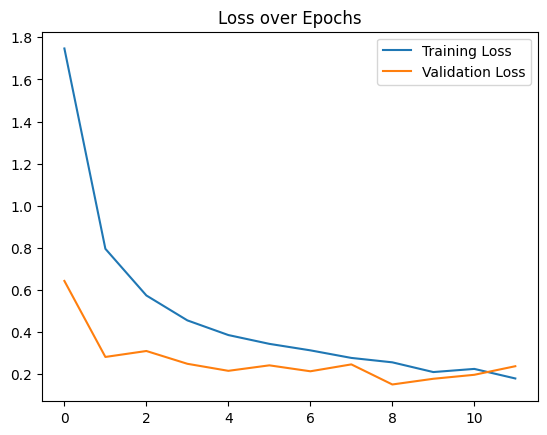

In [51]:
# Visualize Loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title("Loss over Epochs")
plt.show()

### Testing the Accuracy of the Model
This accuracy metric provides insights into how well the trained model generalizes to unseen test data.<br> Adjustments to the model or training process may be made based on the obtained accuracy.

In [52]:
# Calculate the Accuracy of the Model using test data
from sklearn.metrics import accuracy_score

model.eval()
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)  # Get the class index with the highest probability
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 93.96%


## Confusion Matrix
A confusion matrix is generated and visualized to assess the performance of a classification model.<br> The scikit-learn library is utilized for computing the confusion matrix, and the `ConfusionMatrixDisplay` class is employed for an informative graphical representation.

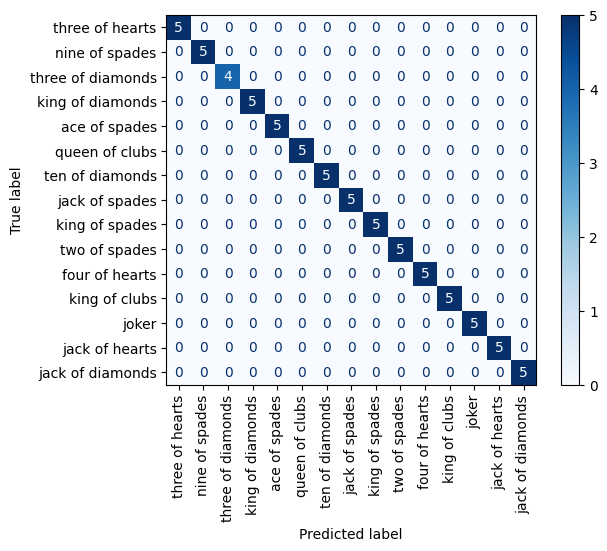

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Identify the top 10 classes based on prediction frequency
top_n_classes = np.argsort(np.bincount(predicted_labels))[::-1][:15]

# Extract the relevant rows and columns from the confusion matrix
conf_matrix_top_n = conf_matrix[top_n_classes][:, top_n_classes]

# Get the class names for the top 10 classes
class_names_top_n = [dataset.classes[i] for i in top_n_classes]

# Display the confusion matrix for the top 10 classes with rotated labels
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_top_n, display_labels=class_names_top_n)
disp.plot(cmap='Blues', values_format='d', xticks_rotation=90)
plt.show()


# Model Evaluation

The trained model is utilized for inference on a set of randomly selected test images. The predictions are visualized alongside the original images using a bar chart to display class probabilities.

This section allows for a qualitative assessment of the model's performance on individual images, providing insights into its ability to correctly classify playing cards.


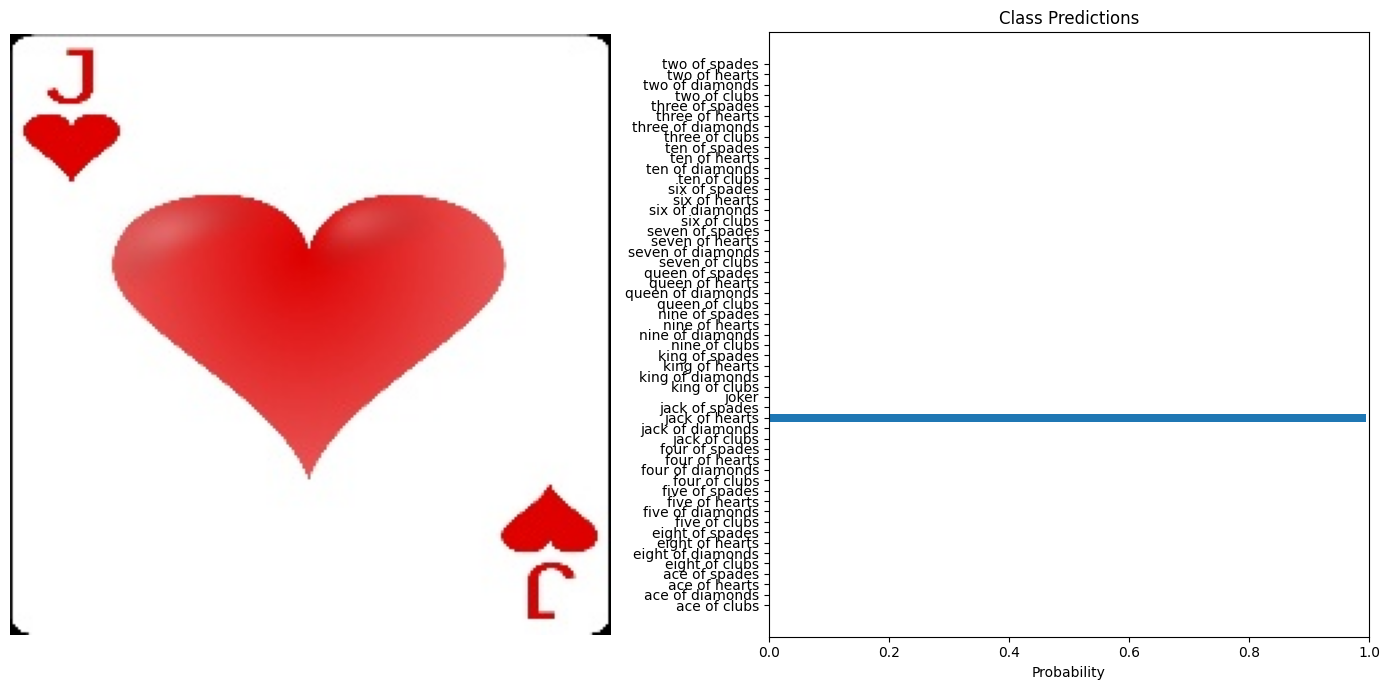

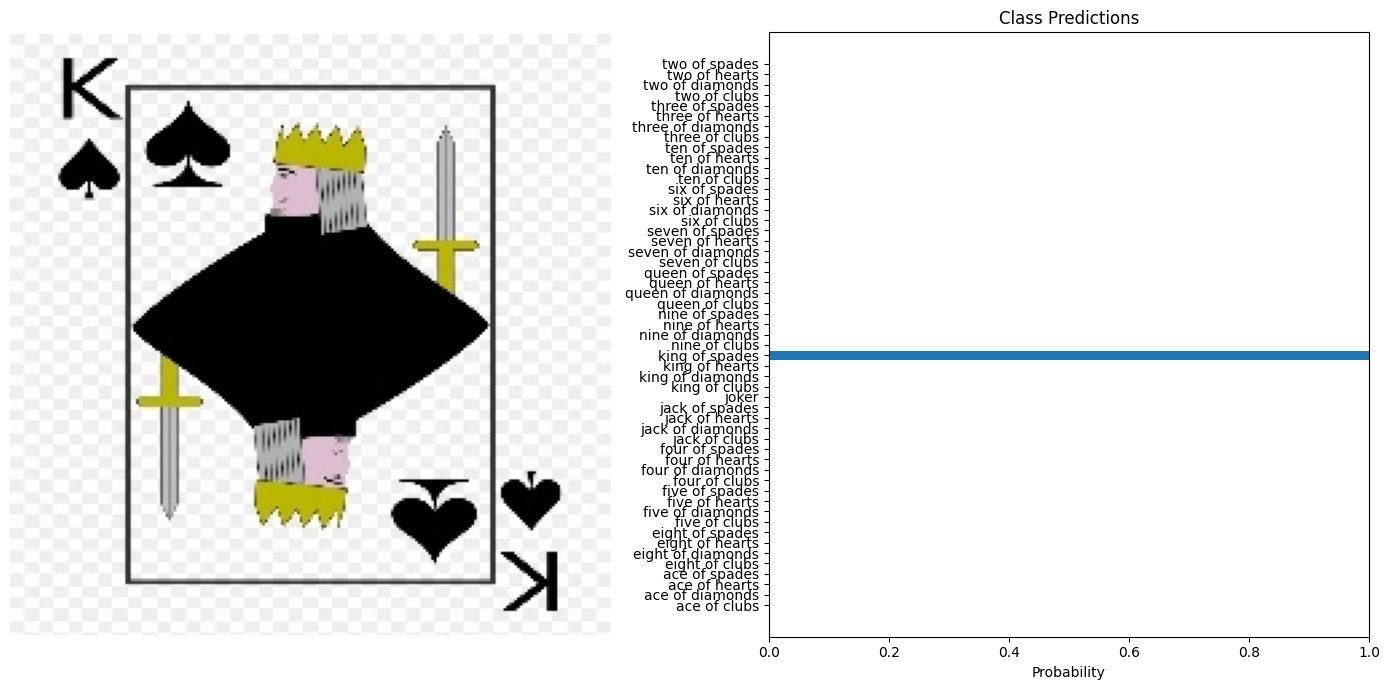

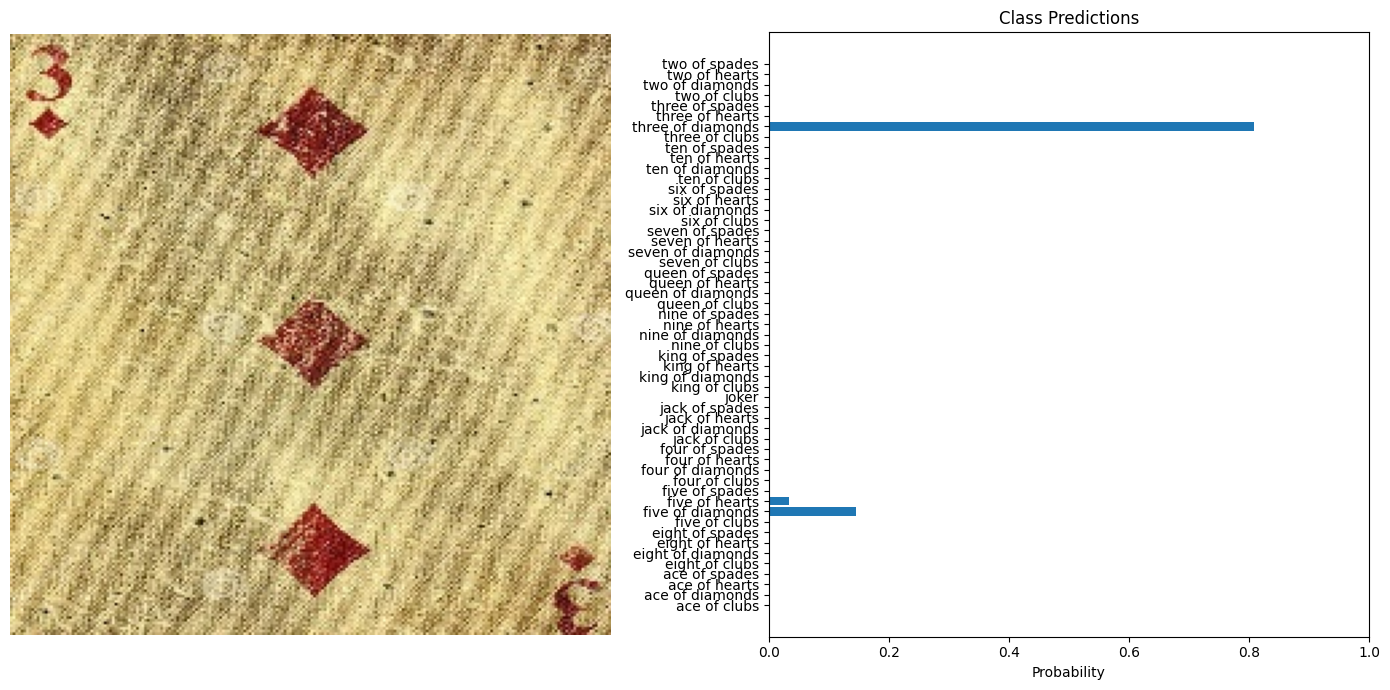

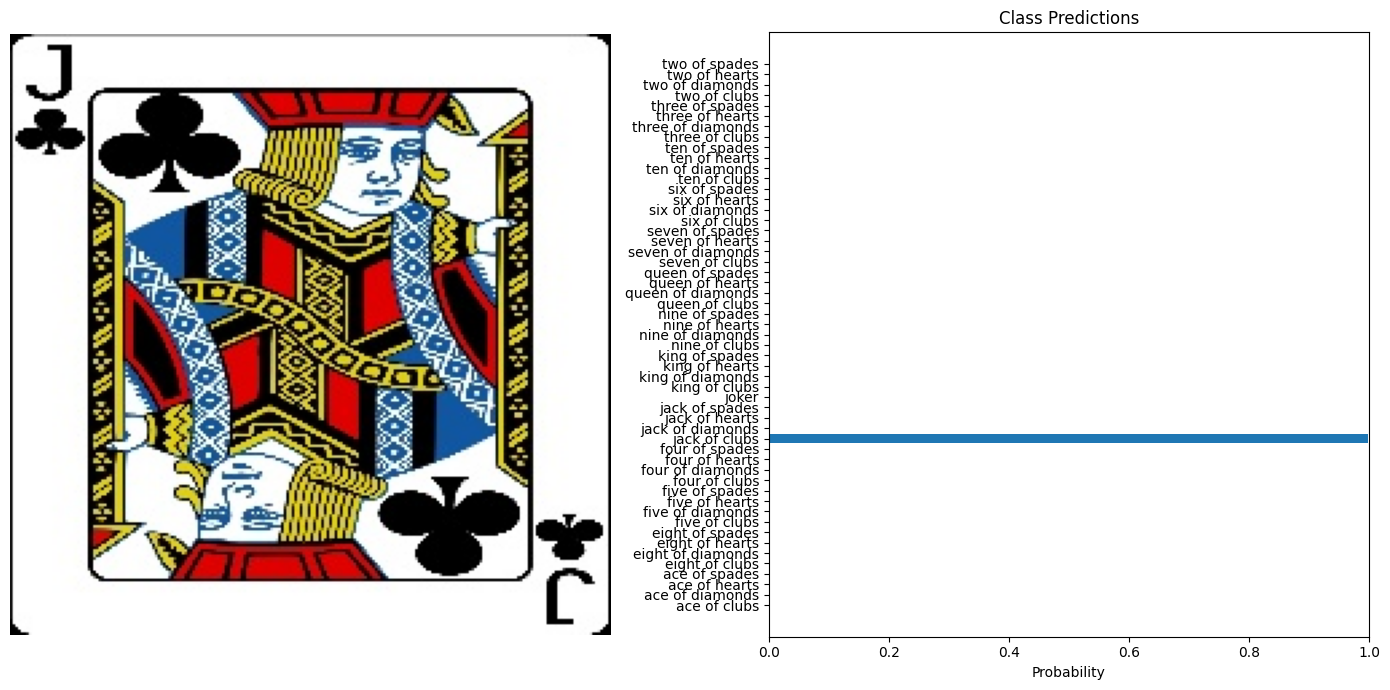

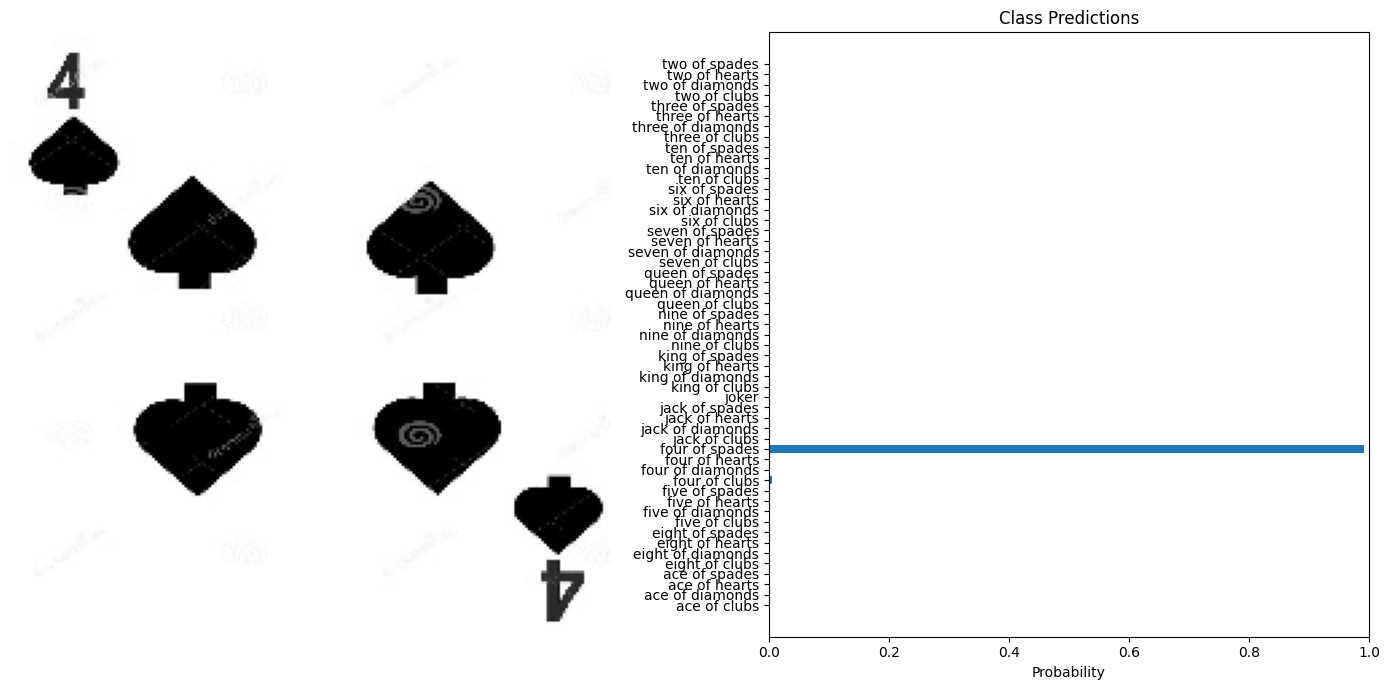

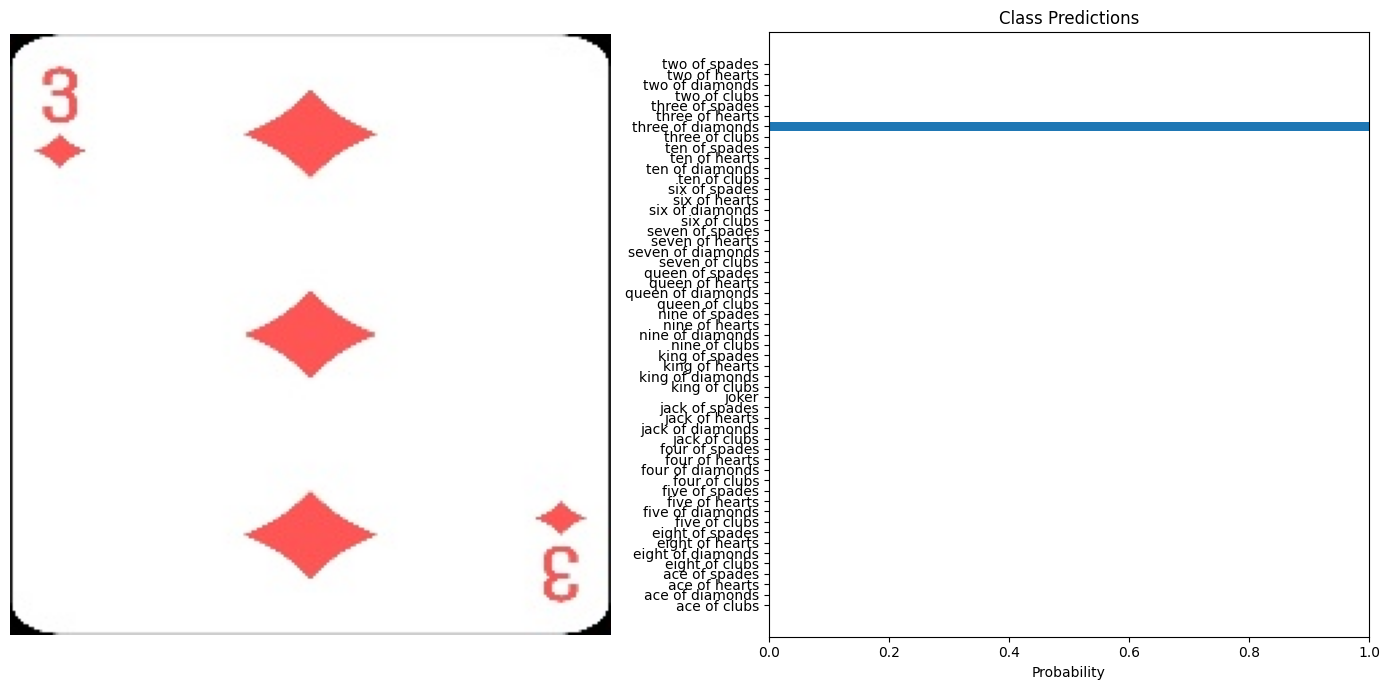

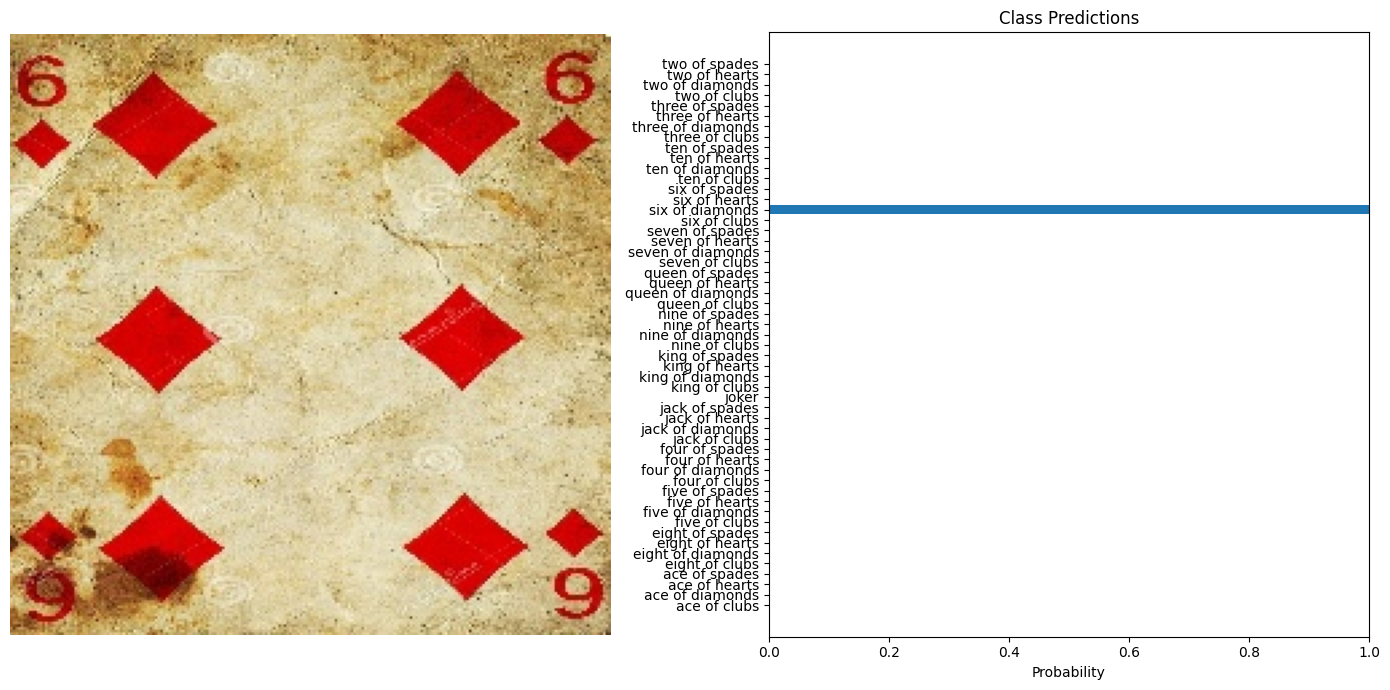

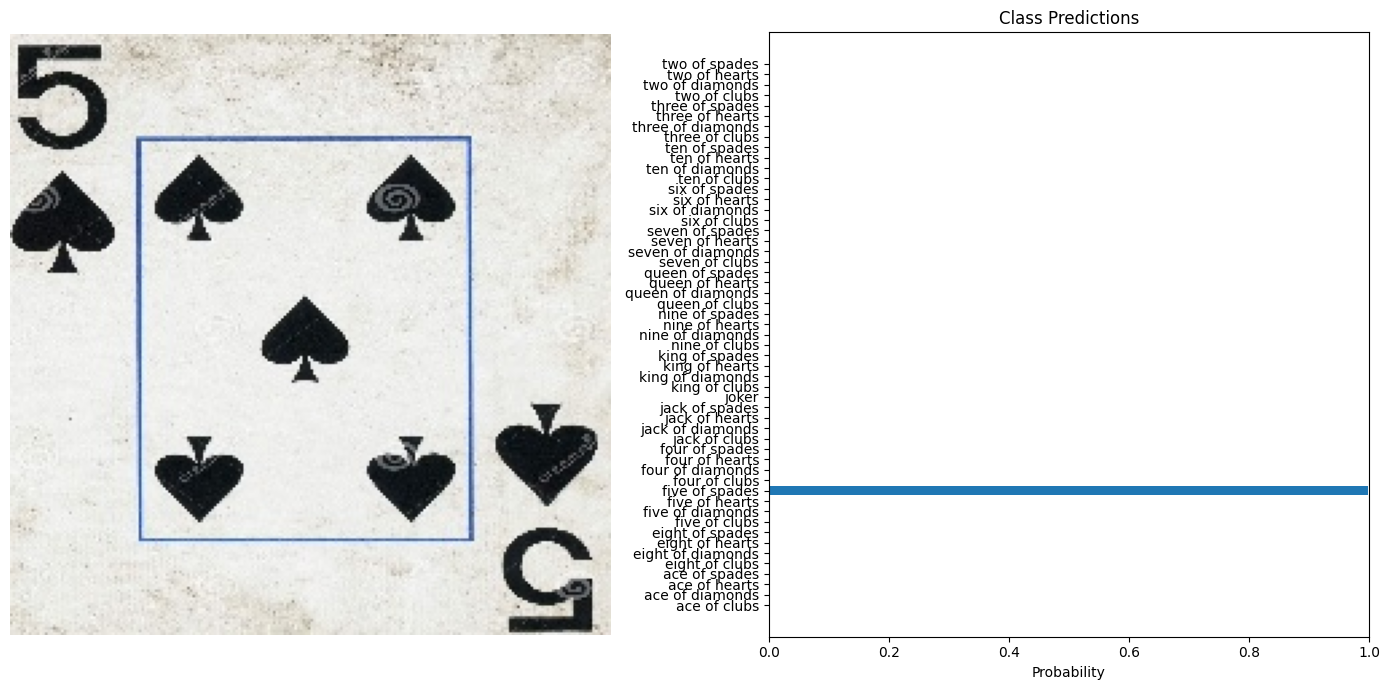

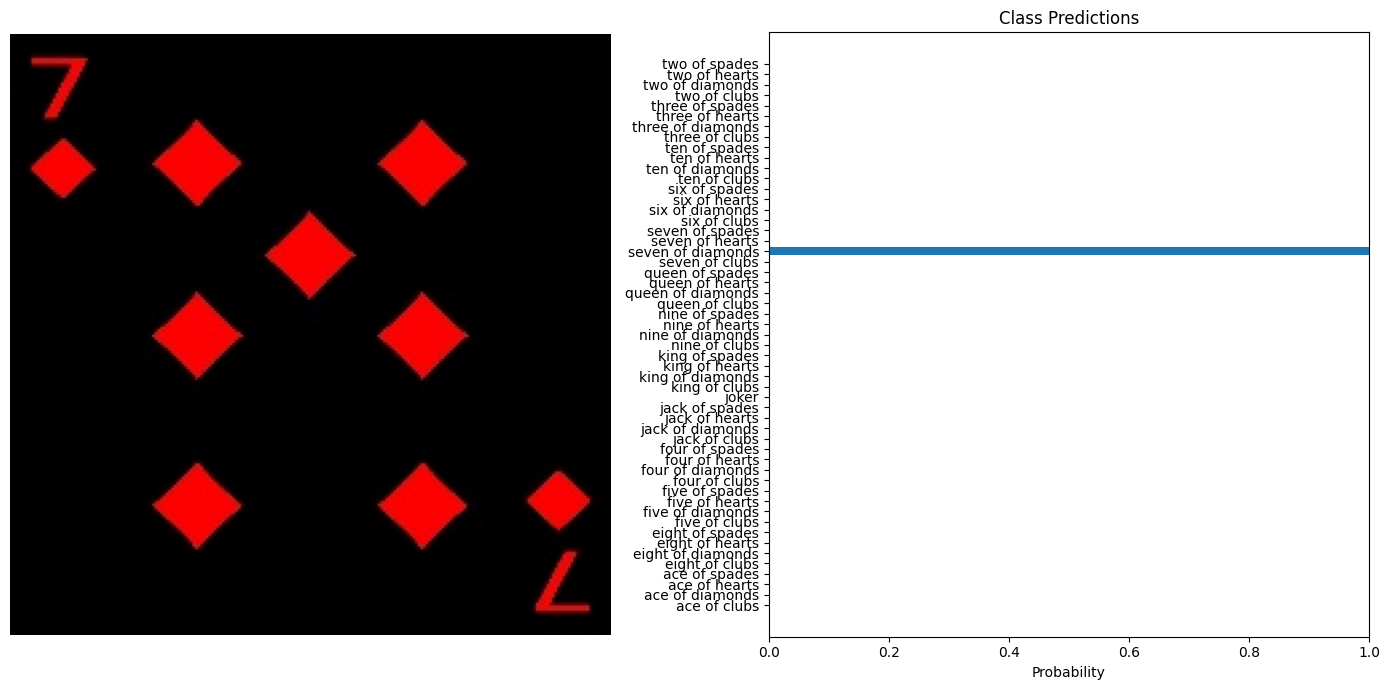

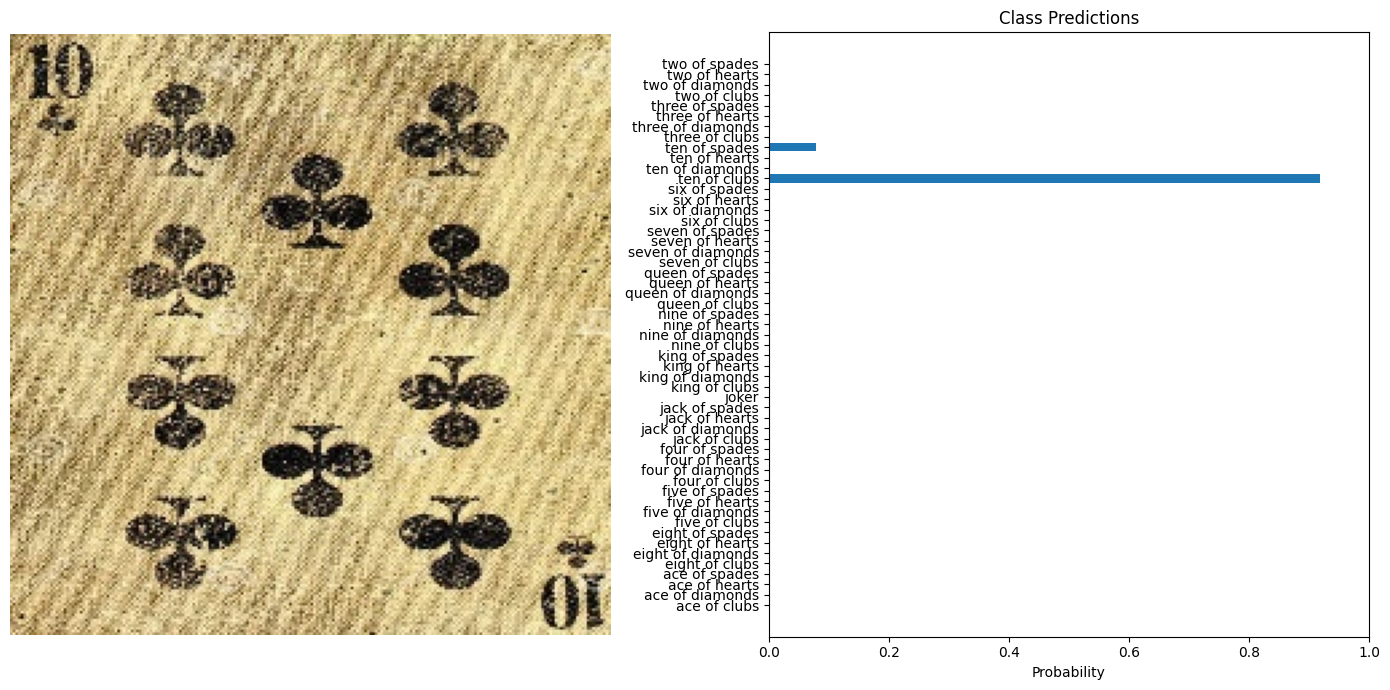

In [54]:
# Evaluation

from PIL import Image
from glob import glob

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1) # convert raw model output (logits) into probability distributions over multiple classes
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
from glob import glob
test_images = glob('./dataset/test/*/*')
test_examples = np.random.choice(test_images, 10)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)

    # Assuming dataset.classes gives the class names
    class_names = dataset.classes 
    visualize_predictions(original_image, probabilities, class_names)

# Github Location

Explore the complete source code and project details on GitHub:

[pytorch-cnn-playing-cards-classifier](https://github.com/hiroonwijekoon/pytorch-cnn-playing-cards-classifier)


# References

1. [PyTorch Model - Card Classifier](https://www.kaggle.com/code/robikscube/train-your-first-pytorch-model-card-classifier)
2. [CNN - 92.45% Accuracy - 92% F1](https://www.kaggle.com/code/efrainp23/cnn-92-45-accuracy-92-f1)
